In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import concatenate,Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate,Dropout,Softmax,BatchNormalization,Activation,DepthwiseConv2D ,ReLU,Add,GlobalAveragePooling2D,Multiply,Average
from keras.optimizers import Adam
import keras.backend as K
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer,label_binarize
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
from keras.preprocessing import image
from keras.utils import load_img,img_to_array,array_to_img
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
import numpy as np
import cv2
import seaborn as sns
import keras
import matplotlib.cm as cm
import gc
from numba import cuda
from itertools import cycle

In [2]:
dataset_path = r'D:\New Plant Diseases Dataset(Augmented)\train'

images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

images_array = np.array(images)
labels_array = np.array(labels)

In [3]:
# Split the dataset as train:val:test = 70:15:15
x_train, x_other, y_train, y_other = train_test_split(images_array, labels_array, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_other, y_other, test_size=0.5, random_state=42)

df_train = pd.DataFrame({'image': x_train, 'label': y_train})
df_val = pd.DataFrame({'image': x_val, 'label': y_val})
df_test = pd.DataFrame({'image': x_test, 'label': y_test})

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

In [4]:
input_shape=(50, 50, 3)
batch_size = 32
num_classes = 38

datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 49206 validated image filenames belonging to 38 classes.
Found 10544 validated image filenames belonging to 38 classes.
Found 10545 validated image filenames belonging to 38 classes.


In [5]:
def channel_attention(input_tensor, reduction_ratio=8):
    channels = input_tensor.shape[-1]
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    fc1 = tf.keras.layers.Dense(channels // reduction_ratio)(avg_pool)
    relu = tf.keras.layers.ReLU()(fc1)
    fc2 = tf.keras.layers.Dense(channels)(relu)
    sigmoid = tf.keras.layers.Activation('sigmoid')(fc2)
    attention = tf.keras.layers.Reshape((1, 1, channels))(sigmoid)
    scaled_input = tf.math.multiply(input_tensor, attention)
    return scaled_input

def spatial_attention(input_tensor):
    avg_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_tensor)
    max_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_tensor)
    concat = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
    attention = tf.keras.layers.Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    scaled_input = tf.math.multiply(input_tensor, attention)
    return scaled_input

In [6]:
def residual_block(x, filters, kernel_size=3, strides=1):
    # Shortcut connection
    shortcut = x

    # First convolutional layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolutional layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Attention layers
    attention = channel_attention(x)
    attention = spatial_attention(attention)
    x = Multiply()([x, attention])
        
    # Element-wise addition
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def resnet(input_shape, num_classes, num_blocks=[2, 2, 2, 2]):
    input_tensor = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(64, (2, 2), strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual blocks
    for block_num in range(len(num_blocks)):
        filters = 64 * (2 ** block_num)
        for _ in range(num_blocks[block_num]):
            if block_num > 0 and _ == 0:
                # Downsample for the first block in each group (except the first group)
                x = residual_block(x, filters, strides=2)
            else:
                x = residual_block(x, filters)
    
    # Global average pooling and dense layer
    x = GlobalAveragePooling2D()(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_tensor, outputs=output_tensor)

    return model

In [7]:
model = resnet(input_shape, num_classes)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 25, 25, 64)   832         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 25, 25, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 25, 25, 64)   0           ['batch_normalization[0][0]']

 activation_1 (Activation)      (None, 64)           0           ['dense_3[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 1, 64)     0           ['activation_1[0][0]']           
                                                                                                  
 tf.math.multiply_2 (TFOpLambda  (None, 25, 25, 64)  0           ['batch_normalization_4[0][0]',  
 )                                                                'reshape_1[0][0]']              
                                                                                                  
 lambda_2 (Lambda)              (None, 25, 25, 1)    0           ['tf.math.multiply_2[0][0]']     
                                                                                                  
 lambda_3 (Lambda)              (None, 25, 25, 1)    0           ['tf.math.multiply_2[0][0]']     
          

 batch_normalization_8 (BatchNo  (None, 13, 13, 128)  512        ['conv2d_11[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 re_lu_10 (ReLU)                (None, 13, 13, 128)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_12 (Conv2D)             (None, 13, 13, 128)  147584      ['re_lu_10[0][0]']               
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 13, 13, 128)  512        ['conv2d_12[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 global_av

 conv2d_17 (Conv2D)             (None, 7, 7, 1)      99          ['concatenate_4[0][0]']          
                                                                                                  
 tf.math.multiply_9 (TFOpLambda  (None, 7, 7, 256)   0           ['tf.math.multiply_8[0][0]',     
 )                                                                'conv2d_17[0][0]']              
                                                                                                  
 conv2d_16 (Conv2D)             (None, 7, 7, 256)    33024       ['re_lu_12[0][0]']               
                                                                                                  
 multiply_4 (Multiply)          (None, 7, 7, 256)    0           ['batch_normalization_11[0][0]', 
                                                                  'tf.math.multiply_9[0][0]']     
                                                                                                  
 batch_nor

                                                                 ]']                              
                                                                                                  
 re_lu_20 (ReLU)                (None, 64)           0           ['dense_12[0][0]']               
                                                                                                  
 dense_13 (Dense)               (None, 512)          33280       ['re_lu_20[0][0]']               
                                                                                                  
 activation_6 (Activation)      (None, 512)          0           ['dense_13[0][0]']               
                                                                                                  
 reshape_6 (Reshape)            (None, 1, 1, 512)    0           ['activation_6[0][0]']           
                                                                                                  
 tf.math.m

                                                                  're_lu_21[0][0]']               
                                                                                                  
 re_lu_24 (ReLU)                (None, 4, 4, 512)    0           ['add_7[0][0]']                  
                                                                                                  
 global_average_pooling2d_8 (Gl  (None, 512)         0           ['re_lu_24[0][0]']               
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_16 (Dense)               (None, 38)           19494       ['global_average_pooling2d_8[0][0
                                                                 ]']                              
                                                                                                  
Total para

In [9]:
# Define the accuracy and loss functions
def my_accuracy(y_true, y_pred):
    pred_labels = tf.argmax(y_pred, axis=-1)
    true_labels = tf.argmax(y_true, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(pred_labels, true_labels), tf.float32))
    return accuracy

def my_loss(y_true, y_pred):
    square = tf.square(y_true - y_pred)
    loss = tf.reduce_mean(square)
    return loss

In [10]:
# Set the learning rate
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_steps = 9
    if epoch % decay_steps == 0 and epoch > 0:
        return lr * decay_rate
    return lr

lr_decay_callback = LearningRateScheduler(lr_scheduler)
optimizer = Adam(learning_rate=0.001)

In [11]:
# Compile the model
model.compile(loss=my_loss, optimizer=optimizer, metrics=[my_accuracy])

In [12]:
# Set early stopping
# earlystop_callback = EarlyStopping(monitor='val_loss',min_delta=0.1,mode='min',patience=2)

In [13]:
history = model.fit(train_generator,epochs=15,batch_size=32,validation_data=val_generator,callbacks=[lr_decay_callback])

Epoch 1/15
1538/1538 [==============================] - 120s 75ms/step - loss: 0.0223 - my_accuracy: 0.2552 - val_loss: 0.0203 - val_my_accuracy: 0.3953 - lr: 0.0010
Epoch 2/15
1538/1538 [==============================] - 118s 77ms/step - loss: 0.0118 - my_accuracy: 0.6709 - val_loss: 0.0179 - val_my_accuracy: 0.5066 - lr: 0.0010
Epoch 3/15
1538/1538 [==============================] - 117s 76ms/step - loss: 0.0084 - my_accuracy: 0.7775 - val_loss: 0.0119 - val_my_accuracy: 0.6710 - lr: 0.0010
Epoch 4/15
1538/1538 [==============================] - 119s 77ms/step - loss: 0.0065 - my_accuracy: 0.8297 - val_loss: 0.0074 - val_my_accuracy: 0.8045 - lr: 0.0010
Epoch 5/15
1538/1538 [==============================] - 119s 77ms/step - loss: 0.0053 - my_accuracy: 0.8606 - val_loss: 0.0089 - val_my_accuracy: 0.7730 - lr: 0.0010
Epoch 6/15
1538/1538 [==============================] - 119s 77ms/step - loss: 0.0045 - my_accuracy: 0.8856 - val_loss: 0.0099 - val_my_accuracy: 0.7495 - lr: 0.0010
Epoc

In [14]:
# Evaluate the ensemble model on the test set
test_loss_ensemble, test_acc_ensemble = model.evaluate(test_generator)
print("Test Accuracy:", test_acc_ensemble)
print("Test Loss:", test_loss_ensemble)

330/330 [==============================] - 18s 53ms/step - loss: 0.0010 - my_accuracy: 0.9743
Test Accuracy: 0.974337100982666
Test Loss: 0.0010343343019485474


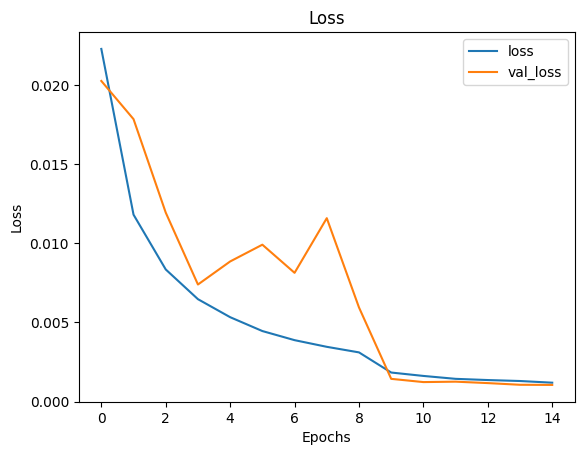

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

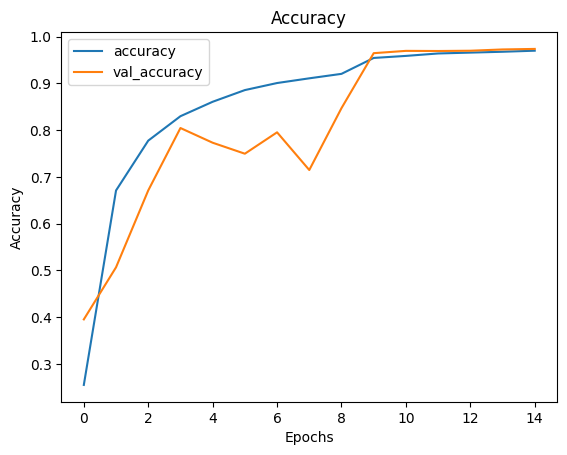

In [16]:
plt.plot(history.history['my_accuracy'], label='accuracy')
plt.plot(history.history['val_my_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [17]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred,axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred_classes)
rice_names = df_test["label"].unique()
print(classification_report(y_true, y_pred_classes, target_names=rice_names))

330/330 [==============================] - 14s 42ms/step
                                                    precision    recall  f1-score   support

                       Corn_(maize)___Common_rust_       0.97      0.99      0.98       328
     Tomato___Spider_mites Two-spotted_spider_mite       0.98      0.99      0.98       280
                              Tomato___Target_Spot       0.96      0.99      0.97       243
                                  Tomato___healthy       0.98      0.96      0.97       299
                          Apple___Cedar_apple_rust       0.97      0.97      0.97       261
                 Cherry_(including_sour)___healthy       0.98      0.97      0.97       265
                      Tomato___Tomato_mosaic_virus       1.00      0.98      0.99       257
                              Tomato___Late_blight       0.96      0.90      0.93       256
                                  Potato___healthy       1.00      0.99      1.00       316
                      

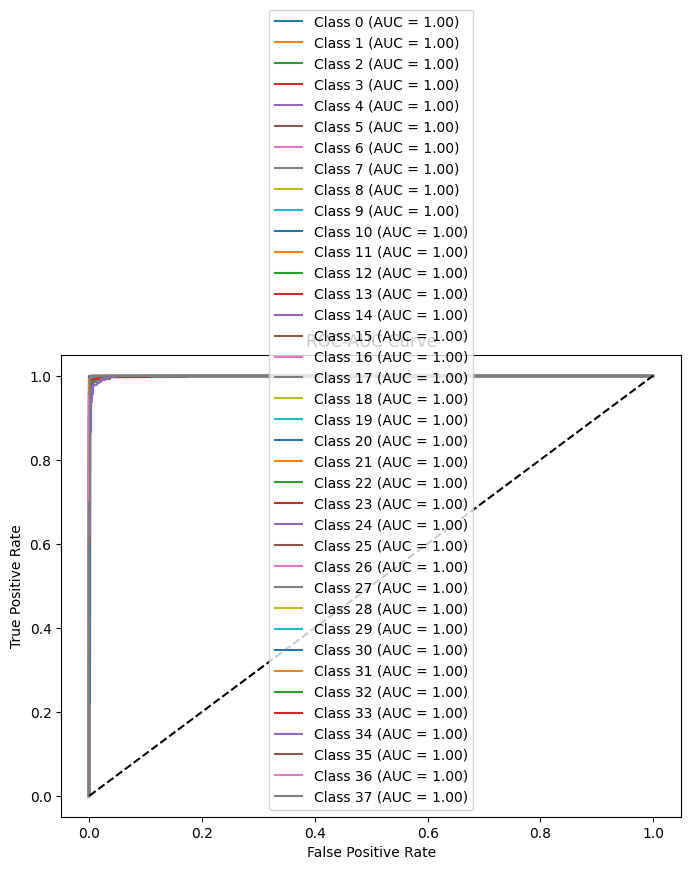

In [18]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true, y_pred[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()

In [19]:
cm = confusion_matrix(y_true, y_pred_classes)
sensitivity_per_class = recall_score(y_true, y_pred_classes, average=None)
specificity_per_class = []
for i in range(cm.shape[0]):
    true_negatives = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    false_positives = np.sum(cm[:, i]) - cm[i, i]
    specificity_per_class.append(true_negatives / (true_negatives + false_positives))

print("Sensitivity of Each Class:", sensitivity_per_class)
print("Specificity of Each Class:", specificity_per_class)

Sensitivity of Each Class: [0.98780488 0.98571429 0.98765432 0.95986622 0.96934866 0.96603774
 0.98054475 0.90234375 0.99050633 0.97857143 1.         0.97577855
 0.97752809 0.99591837 0.98425197 0.99079755 0.98976109 0.99298246
 0.97586207 0.95945946 0.99354839 0.99315068 0.98876404 0.97328244
 0.96896552 0.98818898 0.99606299 0.99632353 0.95020747 0.89830508
 0.95555556 0.98947368 0.95402299 0.97278912 0.90181818 0.96206897
 0.98905109 0.9844358 ]
Specificity of Each Class: [0.9989233630224136, 0.9995129079396006, 0.9990293146961755, 0.9993168065586571, 0.9991248541423571, 0.9994163424124514, 0.999902799377916, 0.9991252794246283, 1.0, 0.9977593765221627, 0.9998053149031442, 0.9991224648985959, 0.9997081144191476, 0.9997087378640777, 0.9997084831406083, 0.9996085722673451, 0.9989270386266095, 0.9996101364522417, 0.9992198927352511, 0.9994145770319055, 0.9998045920859795, 0.998927143275139, 0.9988324576765908, 0.999416512690849, 0.999512432959532, 0.9996113108541445, 0.9999028277135361

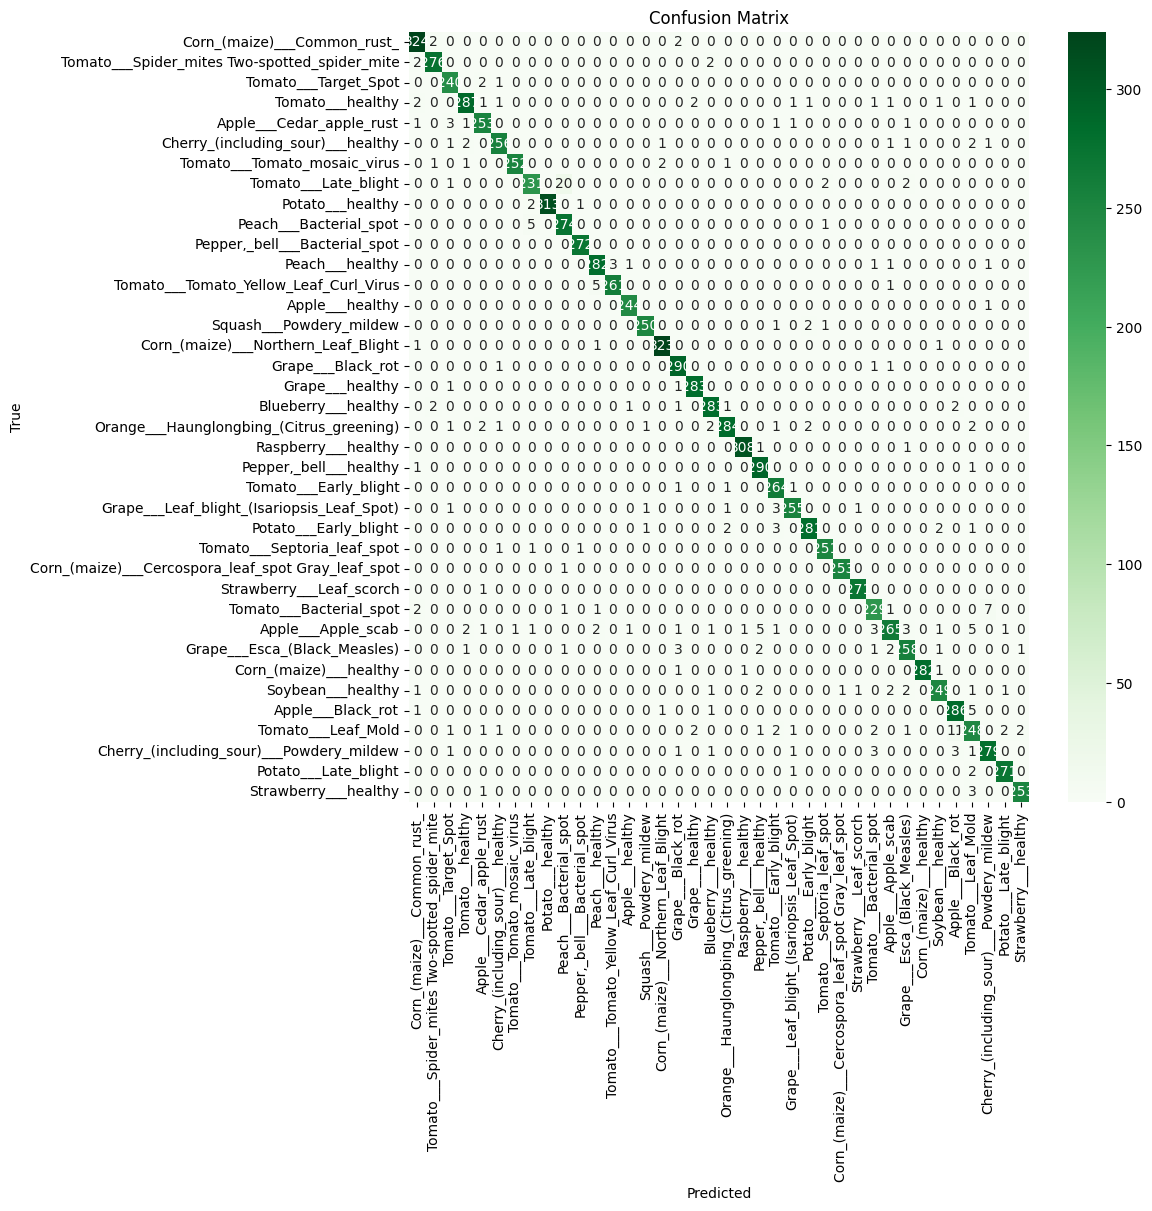

In [20]:
rice_names = df_test["label"].unique()
f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', xticklabels=rice_names, yticklabels=rice_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

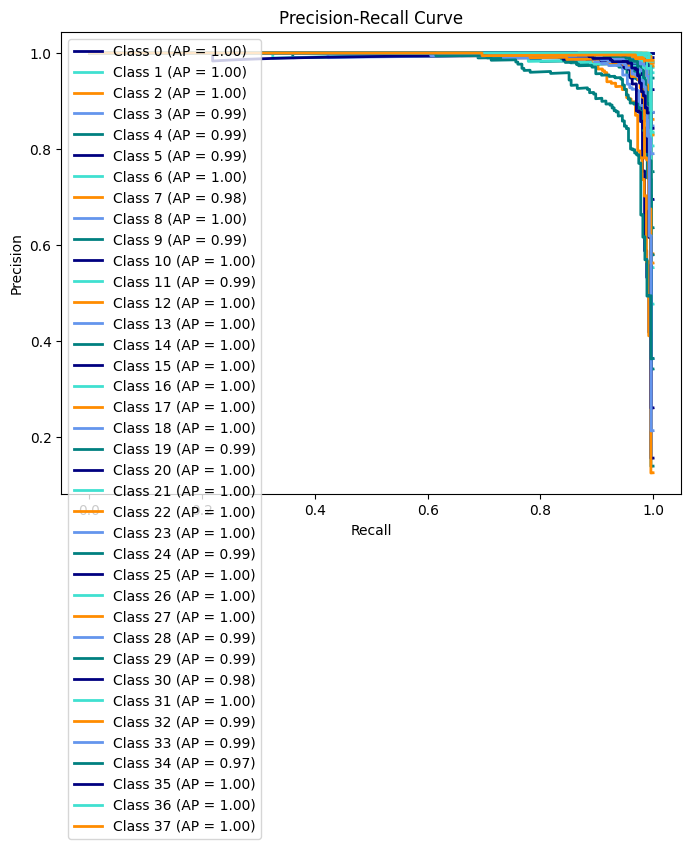

In [21]:
num_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

precision = []
recall = []
average_precision = []

for i in range(num_classes):
    precision_i, recall_i, _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
    average_precision_i = average_precision_score(y_test_bin[:, i], y_pred[:, i])
    precision.append(precision_i)
    recall.append(recall_i)
    average_precision.append(average_precision_i)

plt.figure(figsize=(8, 6))
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
for i, color in zip(range(num_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Class {i} (AP = {average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

In [22]:
K.clear_session()
gc.collect()

9176

In [23]:
cuda.select_device(0)
cuda.close()